# Set up

In [1]:
import numpy as np
import random

In [2]:
SEED = 1234

In [3]:
# Set seed for reproducibility
np.random.seed(SEED)
random.seed(SEED)

# Load data

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/spiral.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,X1,X2,color
0,0.106737,0.114197,c1
1,0.311513,-0.664028,c1
2,0.019870,-0.703126,c1
3,-0.054017,0.508159,c3
4,-0.127751,-0.011382,c3


In [6]:
# Data shapes
X = df[["X1", "X2"]].values
y = df["color"].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1500, 2)
y:  (1500,)


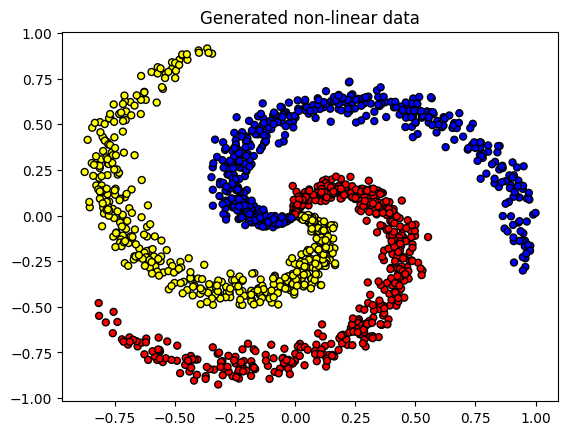

In [7]:
# Visualize data
plt.title("Generated non-linear data")
colors = {"c1": "red", "c2": "yellow", "c3": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors="k", s=25)
plt.show()

# Split Data

In [8]:
import collections
from sklearn.model_selection import train_test_split

In [9]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [10]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [11]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (1050, 2), y_train: (1050,)
X_val: (225, 2), y_val: (225,)
X_test: (225, 2), y_test: (225,)
Sample point: [-0.63919105 -0.69724176] → c1


# Label Encoding

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
# Output vectorizer
label_encoder = LabelEncoder()

In [14]:
# Fit on train data
label_encoder = label_encoder.fit(y_train)
classes = list(label_encoder.classes_)
print (f"classes: {classes}")

classes: ['c1', 'c2', 'c3']


In [15]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: c1
y_train[0]: 0


In [16]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [350 350 350]
weights: {0: 0.002857142857142857, 1: 0.002857142857142857, 2: 0.002857142857142857}


# Standardize data

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [19]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [20]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_test[0]: mean: 0.1, std: 0.9
X_test[1]: mean: 0.0, std: 1.0


# Linear model

In [22]:
import torch

In [23]:
# Set seed for reproducibility
torch.manual_seed(SEED)

# Model

In [25]:
from torch import nn
import torch.nn.functional as F

In [26]:
INPUT_DIM = X_train.shape[1] # X is 2-dimensional
HIDDEN_DIM = 100
NUM_CLASSES = len(classes) # 3 classes

In [27]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in):
        z = self.fc1(x_in) # linear activation
        z = self.fc2(z)
        return z

In [28]:
# Initialize model
model = LinearModel(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of LinearModel(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


# Training

In [29]:
from torch.optim import Adam

In [30]:
LEARNING_RATE = 1e-2
NUM_EPOCHS = 10
BATCH_SIZE = 32

In [31]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [32]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [33]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [34]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [35]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%1==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 1.13, accuracy: 49.9
Epoch: 1 | loss: 0.91, accuracy: 50.3
Epoch: 2 | loss: 0.79, accuracy: 55.3
Epoch: 3 | loss: 0.74, accuracy: 54.6
Epoch: 4 | loss: 0.74, accuracy: 53.7
Epoch: 5 | loss: 0.75, accuracy: 53.6
Epoch: 6 | loss: 0.76, accuracy: 53.7
Epoch: 7 | loss: 0.77, accuracy: 53.8
Epoch: 8 | loss: 0.77, accuracy: 53.9
Epoch: 9 | loss: 0.78, accuracy: 53.9


# Evaluation

In [37]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [38]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [39]:
# Predictions
y_prob = F.softmax(model(X_test), dim=1)
print (f"sample probability: {y_prob[0]}")
y_pred = y_prob.max(dim=1)[1]
print (f"sample class: {y_pred[0]}")

sample probability: tensor([0.8995, 0.0286, 0.0719], grad_fn=<SelectBackward0>)
sample class: 0


In [40]:
# # Performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.5326832791621523,
    "recall": 0.5333333333333333,
    "f1": 0.5327986224880954,
    "num_samples": 225.0
  },
  "class": {
    "c1": {
      "precision": 0.5,
      "recall": 0.5066666666666667,
      "f1": 0.5033112582781457,
      "num_samples": 75.0
    },
    "c2": {
      "precision": 0.5211267605633803,
      "recall": 0.49333333333333335,
      "f1": 0.5068493150684932,
      "num_samples": 75.0
    },
    "c3": {
      "precision": 0.5769230769230769,
      "recall": 0.6,
      "f1": 0.5882352941176471,
      "num_samples": 75.0
    }
  }
}


In [41]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = F.softmax(model(X_test), dim=1)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

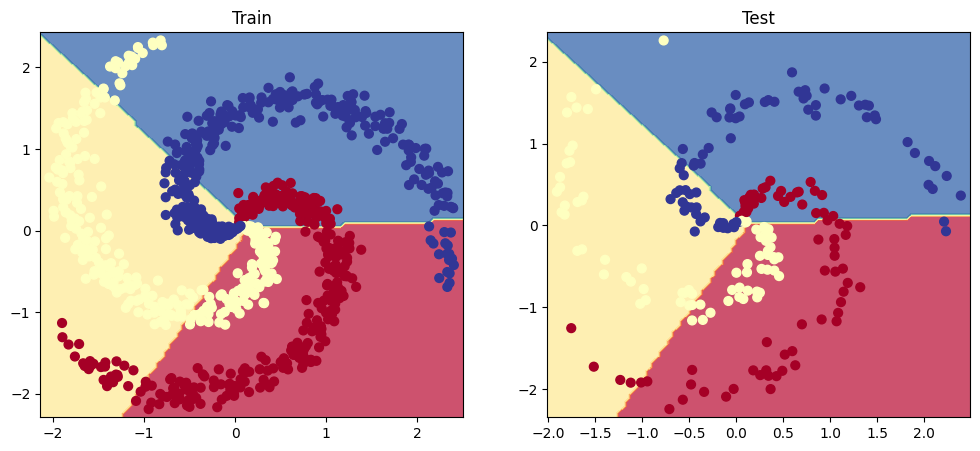

In [42]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

# Activation functions

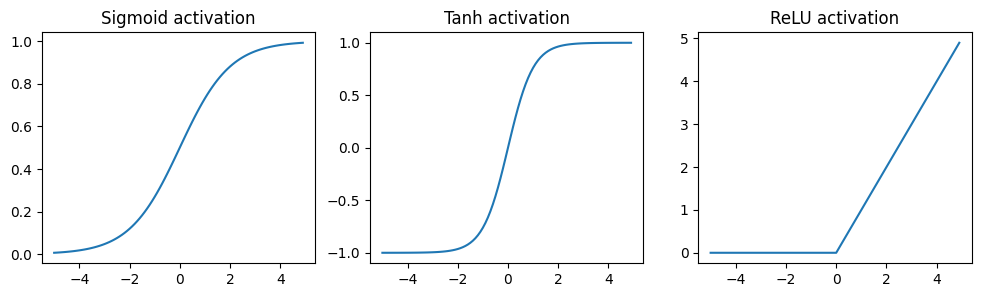

In [43]:
# Fig size
plt.figure(figsize=(12,3))

# Data
x = torch.arange(-5., 5., 0.1)

# Sigmoid activation (constrain a value between 0 and 1.)
plt.subplot(1, 3, 1)
plt.title("Sigmoid activation")
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())

# Tanh activation (constrain a value between -1 and 1.)
plt.subplot(1, 3, 2)
y = torch.tanh(x)
plt.title("Tanh activation")
plt.plot(x.numpy(), y.numpy())

# Relu (clip the negative values to 0)
plt.subplot(1, 3, 3)
y = F.relu(x)
plt.title("ReLU activation")
plt.plot(x.numpy(), y.numpy())

# Show plots
plt.show()

# NumPy

## Initialize weights

In [44]:
# Initialize first layer's weights
W1 = 0.01 * np.random.randn(INPUT_DIM, HIDDEN_DIM)
b1 = np.zeros((1, HIDDEN_DIM))
print (f"W1: {W1.shape}")
print (f"b1: {b1.shape}")

W1: (2, 100)
b1: (1, 100)


## Model

In [45]:
# z1 = [NX2] · [2X100] + [1X100] = [NX100]
z1 = np.dot(X_train, W1) + b1
print (f"z1: {z1.shape}")

z1: (1050, 100)


In [46]:
# Apply activation function
a1 = np.maximum(0, z1) # ReLU
print (f"a_1: {a1.shape}")

a_1: (1050, 100)


In [47]:
# Initialize second layer's weights
W2 = 0.01 * np.random.randn(HIDDEN_DIM, NUM_CLASSES)
b2 = np.zeros((1, NUM_CLASSES))
print (f"W2: {W2.shape}")
print (f"b2: {b2.shape}")

W2: (100, 3)
b2: (1, 3)


In [48]:
# z2 = logits = [NX100] · [100X3] + [1X3] = [NX3]
logits = np.dot(a1, W2) + b2
print (f"logits: {logits.shape}")
print (f"sample: {logits[0]}")

logits: (1050, 3)
sample: [-0.00010001  0.00418463 -0.00067274]


In [49]:
# Normalization via softmax to obtain class probabilities
exp_logits = np.exp(logits)
y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")

y_hat: (1050, 3)
sample: [0.33292037 0.33434987 0.33272975]


## Loss

In [50]:
# Loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
loss = np.sum(correct_class_logprobs) / len(y_train)
print (f"loss: {loss:.2f}")

loss: 1.10


## Gradients

In [51]:
# dJ/dW2
dscores = y_hat
dscores[range(len(y_hat)), y_train] -= 1
dscores /= len(y_train)
dW2 = np.dot(a1.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

In [52]:
# dJ/dW1
dhidden = np.dot(dscores, W2.T)
dhidden[a1 <= 0] = 0 # ReLu backprop
dW1 = np.dot(X_train.T, dhidden)
db1 = np.sum(dhidden, axis=0, keepdims=True)

## Update weights

In [53]:
# Update weights
W1 += -LEARNING_RATE * dW1
b1 += -LEARNING_RATE * db1
W2 += -LEARNING_RATE * dW2
b2 += -LEARNING_RATE * db2

## Training

In [54]:
# Convert tensors to NumPy arrays
X_train = X_train.numpy()
y_train = y_train.numpy()
X_val = X_val.numpy()
y_val = y_val.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

In [55]:
# Initialize random weights
W1 = 0.01 * np.random.randn(INPUT_DIM, HIDDEN_DIM)
b1 = np.zeros((1, HIDDEN_DIM))
W2 = 0.01 * np.random.randn(HIDDEN_DIM, NUM_CLASSES)
b2 = np.zeros((1, NUM_CLASSES))

# Training loop
for epoch_num in range(1000):

    # First layer forward pass [NX2] · [2X100] = [NX100]
    z1 = np.dot(X_train, W1) + b1

    # Apply activation function
    a1 = np.maximum(0, z1) # ReLU

    # z2 = logits = [NX100] · [100X3] = [NX3]
    logits = np.dot(a1, W2) + b2

    # Normalization via softmax to obtain class probabilities
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Loss
    correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
    loss = np.sum(correct_class_logprobs) / len(y_train)

    # show progress
    if epoch_num%100 == 0:
        # Accuracy
        y_pred = np.argmax(logits, axis=1)
        accuracy =  np.mean(np.equal(y_train, y_pred))
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

    # dJ/dW2
    dscores = y_hat
    dscores[range(len(y_hat)), y_train] -= 1
    dscores /= len(y_train)
    dW2 = np.dot(a1.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)

    # dJ/dW1
    dhidden = np.dot(dscores, W2.T)
    dhidden[a1 <= 0] = 0 # ReLu backprop
    dW1 = np.dot(X_train.T, dhidden)
    db1 = np.sum(dhidden, axis=0, keepdims=True)

    # Update weights
    W1 += -1e0 * dW1
    b1 += -1e0 * db1
    W2 += -1e0 * dW2
    b2 += -1e0 * db2

Epoch: 0, loss: 1.099, accuracy: 0.349
Epoch: 100, loss: 0.545, accuracy: 0.687
Epoch: 200, loss: 0.247, accuracy: 0.903
Epoch: 300, loss: 0.142, accuracy: 0.949
Epoch: 400, loss: 0.099, accuracy: 0.974
Epoch: 500, loss: 0.076, accuracy: 0.986
Epoch: 600, loss: 0.062, accuracy: 0.990
Epoch: 700, loss: 0.052, accuracy: 0.994
Epoch: 800, loss: 0.046, accuracy: 0.995
Epoch: 900, loss: 0.041, accuracy: 0.995


## Evaluation

In [56]:
class MLPFromScratch():
    def predict(self, x):
        z1 = np.dot(x, W1) + b1
        a1 = np.maximum(0, z1)
        logits = np.dot(a1, W2) + b2
        exp_logits = np.exp(logits)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return y_hat

In [57]:
# Evaluation
model = MLPFromScratch()
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)

In [58]:
# # Performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.9956140350877192,
    "recall": 0.9955555555555555,
    "f1": 0.9955553580159118,
    "num_samples": 225.0
  },
  "class": {
    "c1": {
      "precision": 1.0,
      "recall": 0.9866666666666667,
      "f1": 0.9932885906040269,
      "num_samples": 75.0
    },
    "c2": {
      "precision": 1.0,
      "recall": 1.0,
      "f1": 1.0,
      "num_samples": 75.0
    },
    "c3": {
      "precision": 0.9868421052631579,
      "recall": 1.0,
      "f1": 0.9933774834437086,
      "num_samples": 75.0
    }
  }
}


In [59]:
def plot_multiclass_decision_boundary_numpy(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.
    Credit: https://cs231n.github.io/neural-networks-case-study/

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot
    if savefig_fp:
        plt.savefig(savefig_fp, format="png")

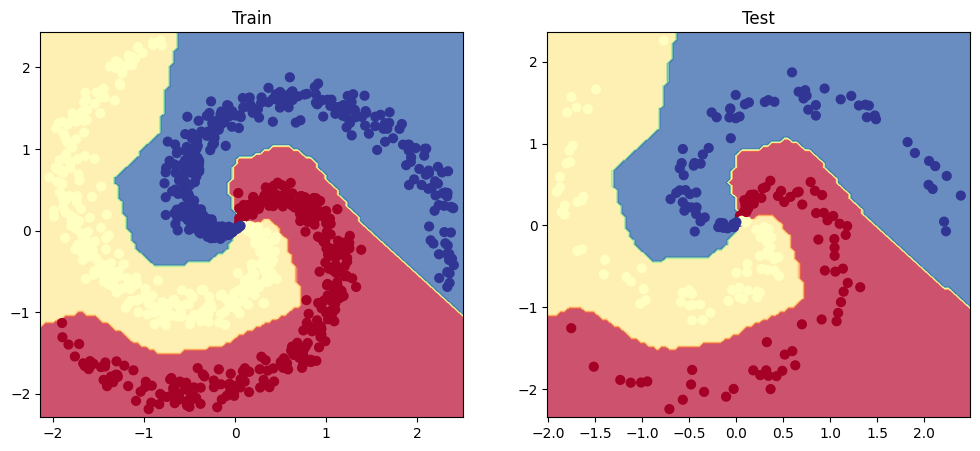

In [60]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary_numpy(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary_numpy(model=model, X=X_test, y=y_test)
plt.show()

# Initializing weights

In [61]:
from torch.nn import init

In [62]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=init.calculate_gain("relu"))

    def forward(self, x_in):
        z = F.relu(self.fc1(x_in)) # ReLU activation function added!
        z = self.fc2(z)
        return z

# Dropout

In [63]:
DROPOUT_P = 0.1 # percentage of weights that are dropped each pass

In [64]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_p, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p) # dropout
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=init.calculate_gain("relu"))

    def forward(self, x_in):
        z = F.relu(self.fc1(x_in))
        z = self.dropout(z) # dropout
        z = self.fc2(z)
        return z

In [65]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM,
            dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


# Overfitting

In [66]:
NUM_EPOCHS = 500
NUM_SAMPLES_PER_CLASS = 50
LEARNING_RATE = 1e-1
HIDDEN_DIM = 2 * NUM_SAMPLES_PER_CLASS * NUM_CLASSES + INPUT_DIM # 2*N*C + D

In [67]:
# Generate random data
X = np.random.rand(NUM_SAMPLES_PER_CLASS * NUM_CLASSES, INPUT_DIM)
y = np.array([[i]*NUM_SAMPLES_PER_CLASS for i in range(NUM_CLASSES)]).reshape(-1)
print ("X: ", format(np.shape(X)))
print ("y: ", format(np.shape(y)))

X:  (150, 2)
y:  (150,)


In [69]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (105, 2), y_train: (105,)
X_val: (22, 2), y_val: (22,)
X_test: (23, 2), y_test: (23,)
Sample point: [0.65613789 0.64046186] → 2


In [70]:
# Standardize the inputs (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [71]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [72]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM,
            dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=302, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=302, out_features=3, bias=True)
)>


In [73]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [74]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%20==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 1.14, accuracy: 27.6
Epoch: 20 | loss: 1.04, accuracy: 46.7
Epoch: 40 | loss: 0.95, accuracy: 53.3
Epoch: 60 | loss: 0.87, accuracy: 62.9
Epoch: 80 | loss: 0.81, accuracy: 69.5
Epoch: 100 | loss: 0.81, accuracy: 65.7
Epoch: 120 | loss: 0.82, accuracy: 63.8
Epoch: 140 | loss: 0.80, accuracy: 61.0
Epoch: 160 | loss: 0.80, accuracy: 64.8
Epoch: 180 | loss: 0.82, accuracy: 63.8
Epoch: 200 | loss: 0.73, accuracy: 71.4
Epoch: 220 | loss: 0.79, accuracy: 67.6
Epoch: 240 | loss: 0.80, accuracy: 64.8
Epoch: 260 | loss: 0.77, accuracy: 66.7
Epoch: 280 | loss: 0.75, accuracy: 66.7
Epoch: 300 | loss: 0.80, accuracy: 60.0
Epoch: 320 | loss: 0.78, accuracy: 67.6
Epoch: 340 | loss: 0.75, accuracy: 68.6
Epoch: 360 | loss: 0.78, accuracy: 71.4
Epoch: 380 | loss: 0.79, accuracy: 66.7
Epoch: 400 | loss: 0.84, accuracy: 61.0
Epoch: 420 | loss: 0.73, accuracy: 67.6
Epoch: 440 | loss: 0.65, accuracy: 74.3
Epoch: 460 | loss: 0.77, accuracy: 65.7
Epoch: 480 | loss: 0.68, accuracy: 72.4


In [75]:
# Predictions
y_prob = F.softmax(model(X_test), dim=1)
y_pred = y_prob.max(dim=1)[1]

In [76]:
# # Performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.5067632850241546,
    "recall": 0.43478260869565216,
    "f1": 0.4450127877237851,
    "num_samples": 23.0
  },
  "class": {
    "c1": {
      "precision": 0.3,
      "recall": 0.42857142857142855,
      "f1": 0.3529411764705882,
      "num_samples": 7.0
    },
    "c2": {
      "precision": 0.75,
      "recall": 0.375,
      "f1": 0.5,
      "num_samples": 8.0
    },
    "c3": {
      "precision": 0.4444444444444444,
      "recall": 0.5,
      "f1": 0.47058823529411764,
      "num_samples": 8.0
    }
  }
}
